Confusion Matrix:
[[ 97  63]
 [ 31 264]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.61      0.67       160
           1       0.81      0.89      0.85       295

    accuracy                           0.79       455
   macro avg       0.78      0.75      0.76       455
weighted avg       0.79      0.79      0.79       455



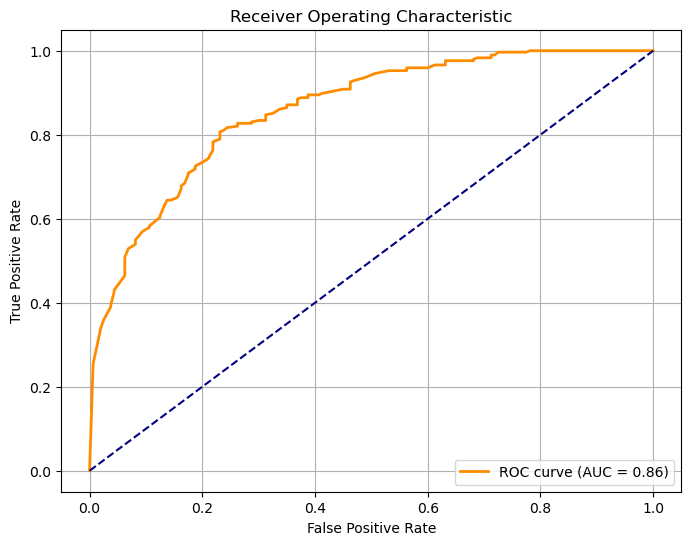

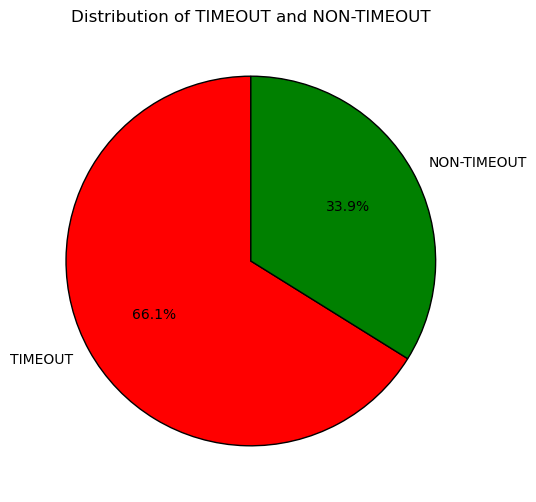


Feature Importances:
                    Feature  Importance
11       var_occurrence_std    0.100168
8         clause_length_std    0.087077
4       clause_to_var_ratio    0.074087
9       max_var_occurrences    0.073238
12              var_density    0.070116
6         max_clause_length    0.065981
0                  num_vars    0.065761
2         avg_clause_length    0.062936
5            clause_density    0.061562
13       avg_var_per_clause    0.061180
15  literal_to_clause_ratio    0.058471
1               num_clauses    0.055925
3            var_counts_sum    0.055005
14            literal_count    0.053489
10      min_var_occurrences    0.045660
7         min_clause_length    0.009345


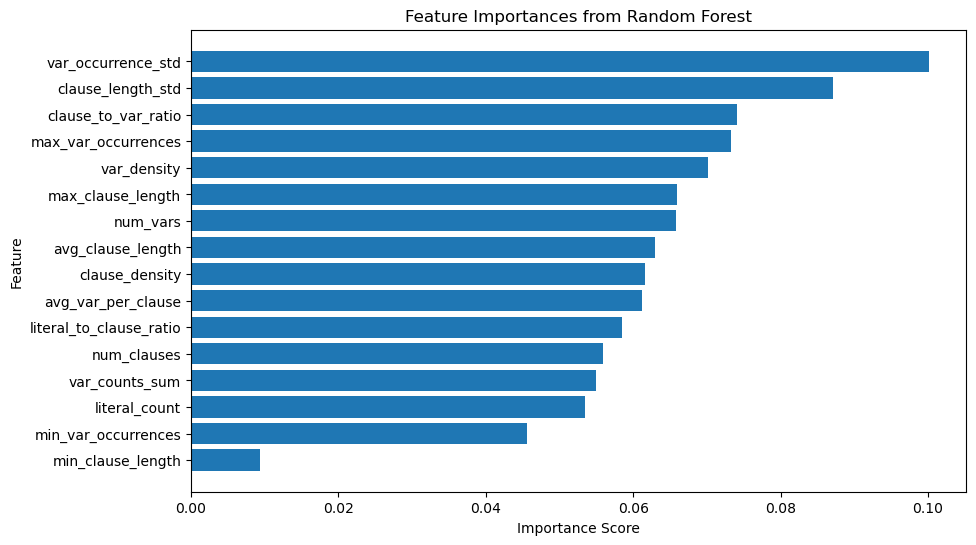

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# 1. load data
file_path = "updated_file.csv"
data = pd.read_csv(file_path)

# TIMEOUT (0)  NON-TIMEOUT (1)

def categorize_result(row):
    return 0 if row['solve_result'] == 'TIMEOUT' else 1

data['solvable'] = data.apply(categorize_result, axis=1)

# Get Features
X = data.drop(columns=['solve_result', 'filename', 'solvable','solve_runtime'], errors='ignore')
y = data['solvable']

# 2. devide data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. RandomForest
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# 4. Training
rf_model.fit(X_train, y_train)

# 5. Prediction
y_pred = rf_model.predict(X_test)

# 6. Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 7. Draw ROC Curve
y_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 8. Draw TIMEOUT
labels = ['TIMEOUT', 'NON-TIMEOUT']
timeout_counts = data['solvable'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(timeout_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'green'], wedgeprops={'edgecolor': 'black'})
plt.title("Distribution of TIMEOUT and NON-TIMEOUT")
plt.show()

# 9. Analyze importances of features
feature_importances = rf_model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances_df)

# Draw table of importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


Original number of features: 16
Reduced number of features after PCA: 8
Original training set distribution: Counter({1: 1207, 0: 609})
Resampled training set distribution: Counter({1: 1207, 0: 1207})


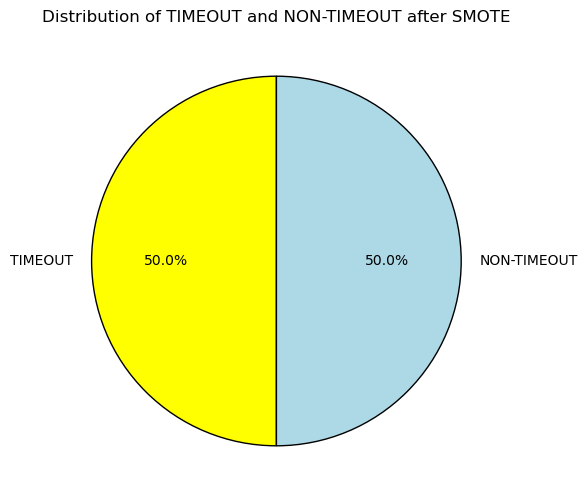

Starting GridSearchCV for hyperparameter tuning...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.2s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.2s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.

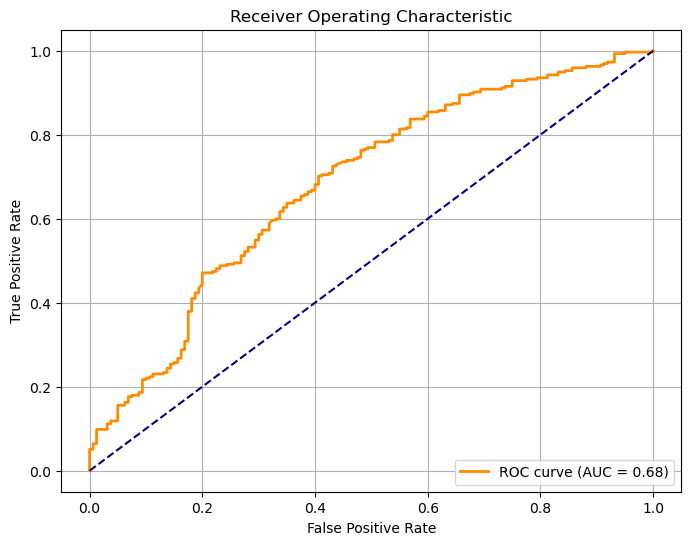

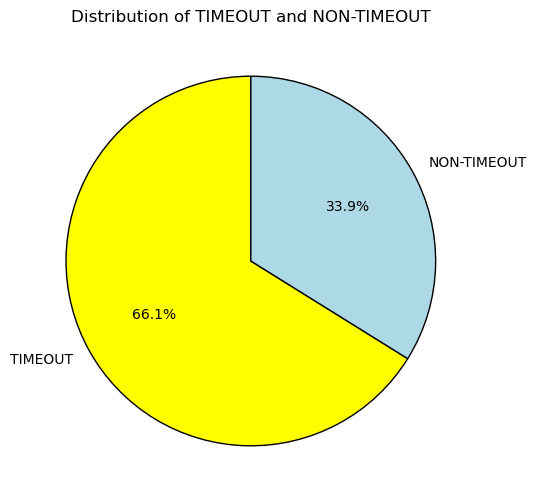

In [9]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# 1. Load Data
file_path = "updated_file.csv"
data = pd.read_csv(file_path)

# TIMEOUT (0)  NON-TIMEOUT (1)
def categorize_result(row):
    return 0 if row['solve_result'] == 'TIMEOUT' else 1

data['solvable'] = data.apply(categorize_result, axis=1)

# Extract Features
X = data.drop(columns=['solve_result', 'filename', 'solvable','solve_runtime'], errors='ignore')
y = data['solvable']

X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0)

# StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Mapping into a low Dimension
pca = PCA(n_components=0.95, random_state=42) 
X_pca = pca.fit_transform(X_scaled)
print(f"Original number of features: {X_scaled.shape[1]}")
print(f"Reduced number of features after PCA: {X_pca.shape[1]}")

# 2. Devide data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# 3. SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

from collections import Counter
print("Original training set distribution:", Counter(y_train))
print("Resampled training set distribution:", Counter(y_train_resampled))

resampled_counts = Counter(y_train_resampled)
labels = ['TIMEOUT', 'NON-TIMEOUT']
plt.figure(figsize=(7, 6))
plt.pie([resampled_counts[0], resampled_counts[1]], labels=labels, autopct='%1.1f%%', startangle=90, colors=['yellow', 'lightblue'], wedgeprops={'edgecolor': 'black'})
plt.title("Distribution of TIMEOUT and NON-TIMEOUT after SMOTE")
plt.savefig("smote.png")
plt.show()

# 4. GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

print("Starting GridSearchCV for hyperparameter tuning...")
grid = GridSearchCV(SVC(class_weight='balanced', probability=True, random_state=42), param_grid, refit=True, verbose=2, cv=3)
grid.fit(X_train_resampled, y_train_resampled)

print("Best parameters found by GridSearchCV:")
print(grid.best_params_)

# 5. Using best parameter
svm_model = grid.best_estimator_

# 6. Prediction
y_pred = svm_model.predict(X_test)

# 7. Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 8. Draw ROC Curve
y_proba = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.savefig("svmroc.png")
plt.show()

labels = ['TIMEOUT', 'NON-TIMEOUT']
timeout_counts = data['solvable'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(timeout_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['yellow', 'lightblue'], wedgeprops={'edgecolor': 'black'})
plt.title("Distribution of TIMEOUT and NON-TIMEOUT")
plt.savefig("no_smote.png")
plt.show()


Confusion Matrix:
[[103  57]
 [143 152]]

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.64      0.51       160
           1       0.73      0.52      0.60       295

    accuracy                           0.56       455
   macro avg       0.57      0.58      0.56       455
weighted avg       0.62      0.56      0.57       455



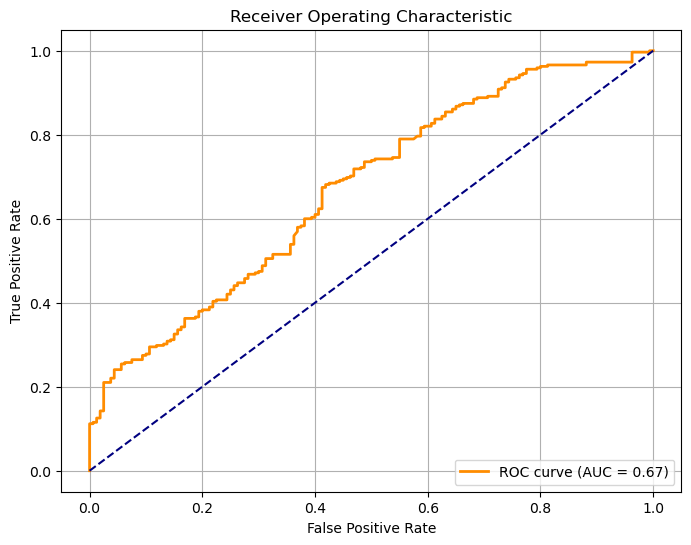

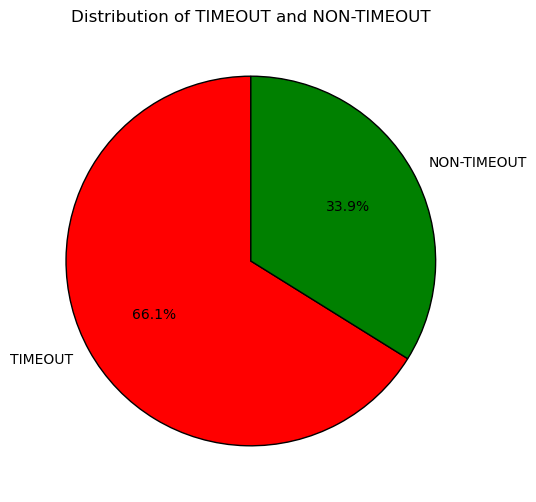

In [92]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1. Load Data
file_path = "updated_file.csv"
data = pd.read_csv(file_path)

# TIMEOUT (0)  NON-TIMEOUT (1)

def categorize_result(row):
    return 0 if row['solve_result'] == 'TIMEOUT' else 1

data['solvable'] = data.apply(categorize_result, axis=1)

# Extract Features
X = data.drop(columns=['solve_result', 'filename', 'solvable','solve_runtime'], errors='ignore')
y = data['solvable']

X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0) 

# StandarScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Devide Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 3. Initialize SVM
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)

# 4. Training
svm_model.fit(X_train, y_train)

# 5. Prediction
y_pred = svm_model.predict(X_test)

# 6. Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 7. Draw ROC Curve
y_proba = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.show()

labels = ['TIMEOUT', 'NON-TIMEOUT']
timeout_counts = data['solvable'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(timeout_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'green'], wedgeprops={'edgecolor': 'black'})
plt.title("Distribution of TIMEOUT and NON-TIMEOUT")
plt.show()


Confusion Matrix:
[[103  57]
 [143 152]]

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.64      0.51       160
           1       0.73      0.52      0.60       295

    accuracy                           0.56       455
   macro avg       0.57      0.58      0.56       455
weighted avg       0.62      0.56      0.57       455



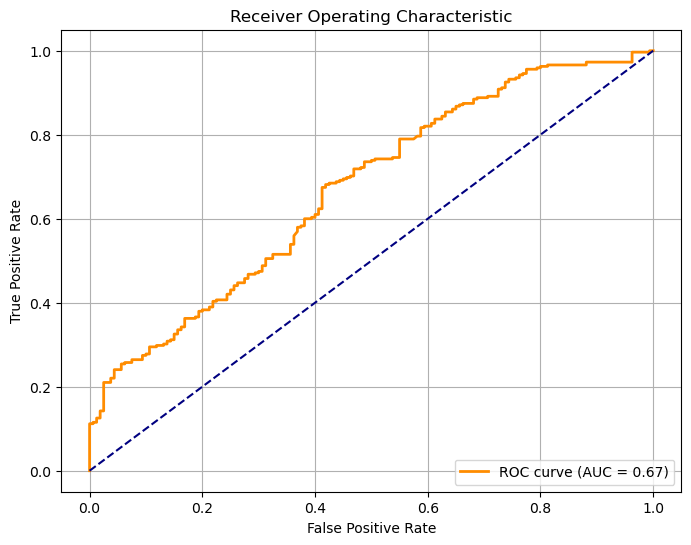

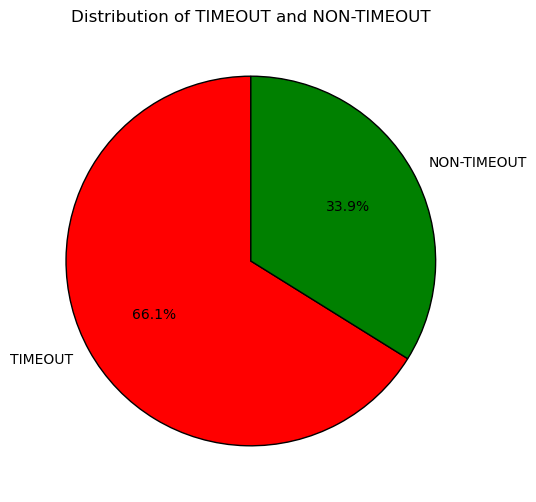

In [92]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1. Load Data
file_path = "updated_file.csv"
data = pd.read_csv(file_path)

# TIMEOUT (0) 和 NON-TIMEOUT (1)

def categorize_result(row):
    return 0 if row['solve_result'] == 'TIMEOUT' else 1

data['solvable'] = data.apply(categorize_result, axis=1)

# Extract Features
X = data.drop(columns=['solve_result', 'filename', 'solvable','solve_runtime'], errors='ignore')
y = data['solvable']

X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0) 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Devide Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 3. initialize SVM
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)

# 4. Training
svm_model.fit(X_train, y_train)

# 5. Prediction
y_pred = svm_model.predict(X_test)

# 6. Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 7. Draw ROC Curve
y_proba = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.show()

labels = ['TIMEOUT', 'NON-TIMEOUT']
timeout_counts = data['solvable'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(timeout_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'green'], wedgeprops={'edgecolor': 'black'})
plt.title("Distribution of TIMEOUT and NON-TIMEOUT")
plt.show()


Confusion Matrix:
[[249  46]
 [ 55 251]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       295
           1       0.85      0.82      0.83       306

    accuracy                           0.83       601
   macro avg       0.83      0.83      0.83       601
weighted avg       0.83      0.83      0.83       601



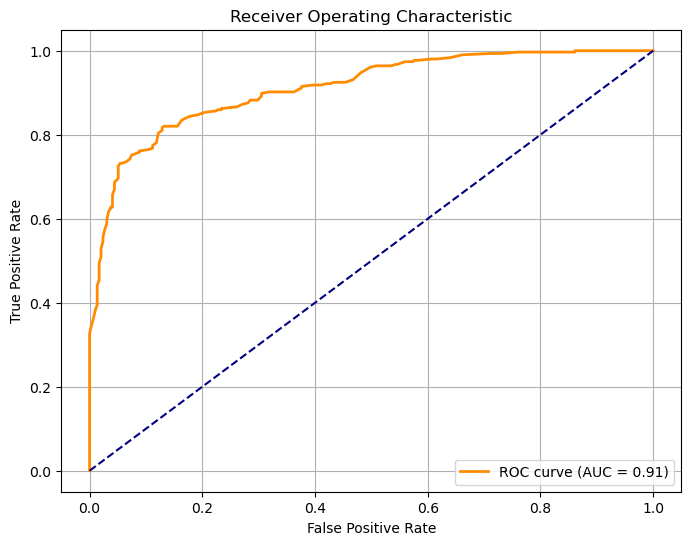

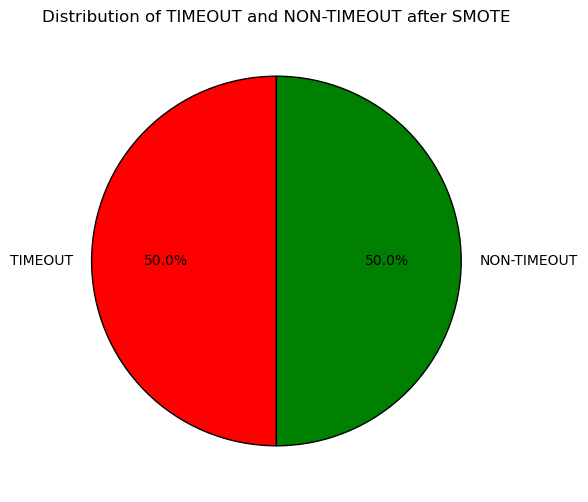


Feature Importances:
                    Feature  Importance
11       var_occurrence_std    0.081499
8         clause_length_std    0.081317
4       clause_to_var_ratio    0.077357
0                  num_vars    0.072628
12              var_density    0.070728
9       max_var_occurrences    0.070688
6         max_clause_length    0.069177
5            clause_density    0.066659
15  literal_to_clause_ratio    0.063459
1               num_clauses    0.060974
2         avg_clause_length    0.059142
13       avg_var_per_clause    0.057708
14            literal_count    0.057514
3            var_counts_sum    0.056546
10      min_var_occurrences    0.043595
7         min_clause_length    0.011009


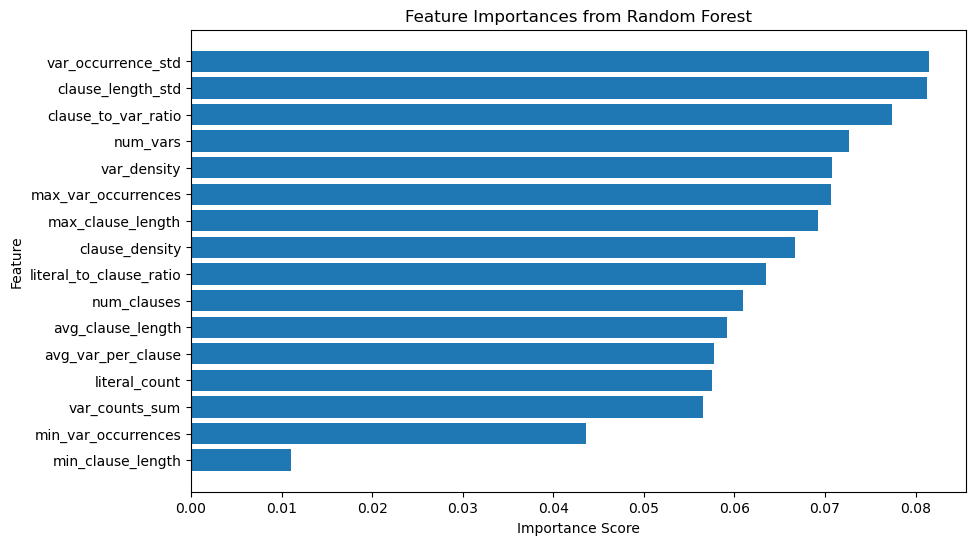

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# 1. Load Data
file_path = "updated_file.csv"
data = pd.read_csv(file_path)

# TIMEOUT (0) NON-TIMEOUT (1)

def categorize_result(row):
    return 0 if row['solve_result'] == 'TIMEOUT' else 1

data['solvable'] = data.apply(categorize_result, axis=1)

# Extract Features
X = data.drop(columns=['solve_result', 'filename', 'solvable', 'solve_runtime'], errors='ignore')
y = data['solvable']

X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0) 

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 2. Devide Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 3. Initialize RandomForest
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# 4. Training
rf_model.fit(X_train, y_train)

# 5. Prediction
y_pred = rf_model.predict(X_test)

# 6. Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 7. Draw ROC Curve
y_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 8. Draw ratio
labels = ['TIMEOUT', 'NON-TIMEOUT']
timeout_counts = pd.Series(y_resampled).value_counts()
plt.figure(figsize=(6, 6))
plt.pie(timeout_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'green'], wedgeprops={'edgecolor': 'black'})
plt.title("Distribution of TIMEOUT and NON-TIMEOUT after SMOTE")
plt.show()

# 9. Analyze Importances
feature_importances = rf_model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.gca().invert_yaxis() 
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


Confusion Matrix:
[[248  47]
 [ 50 256]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       295
           1       0.84      0.84      0.84       306

    accuracy                           0.84       601
   macro avg       0.84      0.84      0.84       601
weighted avg       0.84      0.84      0.84       601



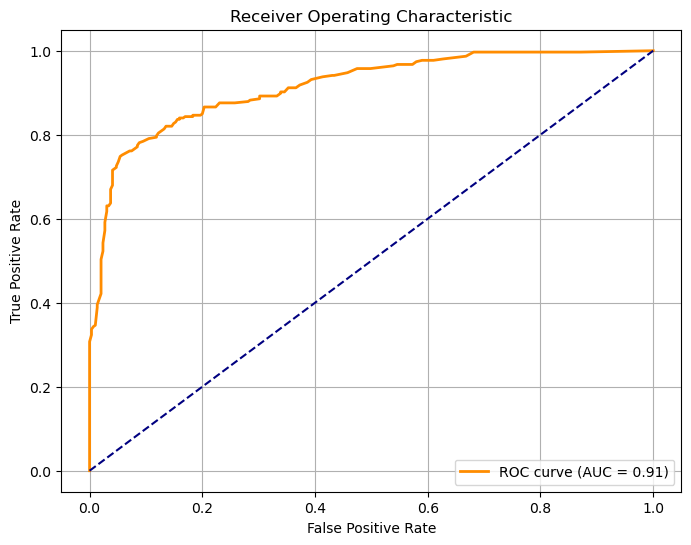

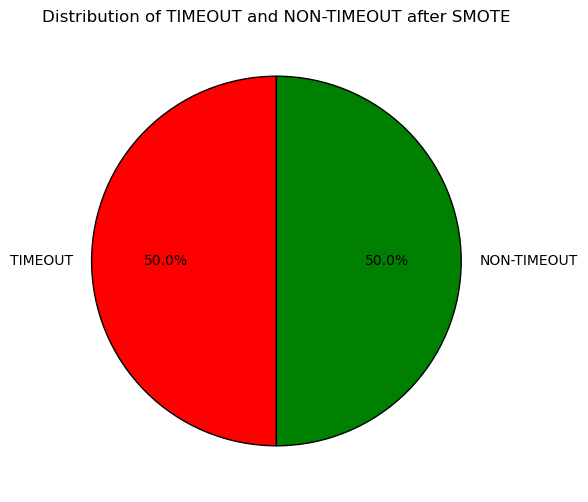


Feature Importances:
                    Feature  Importance
11       var_occurrence_std    0.086214
8         clause_length_std    0.083874
6         max_clause_length    0.081589
4       clause_to_var_ratio    0.073094
12              var_density    0.071778
0                  num_vars    0.070825
9       max_var_occurrences    0.068920
1               num_clauses    0.066151
15  literal_to_clause_ratio    0.060085
5            clause_density    0.058886
3            var_counts_sum    0.056763
14            literal_count    0.056116
2         avg_clause_length    0.055375
13       avg_var_per_clause    0.055092
10      min_var_occurrences    0.042700
7         min_clause_length    0.012539


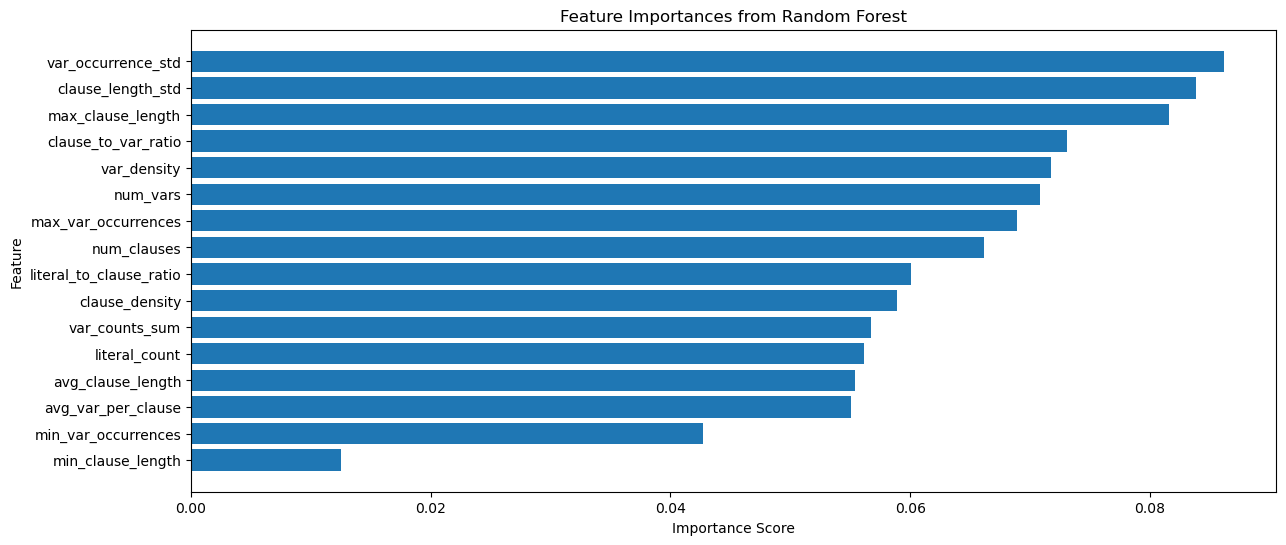

In [29]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# 1. Load Data
file_path = "updated_file.csv"
data = pd.read_csv(file_path)

# TIMEOUT (0)  NON-TIMEOUT (1)

def categorize_result(row):
    return 0 if row['solve_result'] == 'TIMEOUT' else 1

data['solvable'] = data.apply(categorize_result, axis=1)

# Extract Features
X = data.drop(columns=['solve_result', 'filename', 'solvable', 'solve_runtime'], errors='ignore')
y = data['solvable']

X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0)

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 2. Devide Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 3. Initialize RandomForest and increase weight of 0
rf_model = RandomForestClassifier(n_estimators=100, class_weight={0: 4, 1: 1}, random_state=42)

# 4. Training
rf_model.fit(X_train, y_train)

# 5. Prediction
y_pred = rf_model.predict(X_test)

# 6. Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 7. Draw ROC Curve
y_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.savefig("roc.png")
plt.show()


# 8. Draw Ratio
labels = ['TIMEOUT', 'NON-TIMEOUT']
timeout_counts = pd.Series(y_resampled).value_counts()
plt.figure(figsize=(8, 6))
plt.pie(timeout_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'green'], wedgeprops={'edgecolor': 'black'})
plt.title("Distribution of TIMEOUT and NON-TIMEOUT after SMOTE")
plt.savefig("smote.png")
plt.show()


# 9. Analyze Importances
feature_importances = rf_model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances_df)

plt.figure(figsize=(14, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.savefig("importances.png")
plt.show()

